In [1]:
#Read Data From CSV file
import pandas as pd
df=pd.read_csv('NEWDATATABLE.csv', sep=',',header=None)
ratings = df.values

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def train_test_generation(ratings):
    #Cretae train and test matrix
    test = np.ones(ratings.shape) * 99 #24983*100 and initzalize all be unknown 99 and ratings.shape[0] return 24983
    train = ratings.copy()
    #Make all unknown numbers 99 be 0
    train = train - np.ones(ratings.shape) * 99
    for user in xrange(ratings.shape[0]):
        #Randomly pick 10 ratings from each user to be in test case (include unknown ratings)
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size = 20, replace = False)
        #Set chosen be zero in training
        train [user, test_ratings] = 0.
        #Assign chosen rating to test case
        test[user, test_ratings] = ratings[user, test_ratings]
    
    train = train + np.ones(ratings.shape) * 99
    #Make sure train and test are disjoint 
    #assert(np.all((train * test) == 0))
    return train, test

In [4]:
#Call the function and then assign train and test
train, test = train_test_generation(ratings)
#Masked for CF and not masked for SVD
train = np.ma.masked_where(train == 99, train)
test = np.ma.masked_where(test == 99, test)
trainMAE = train.copy()

In [149]:
#Find averge of each column
train_average_column = np.zeros(100)
for indexI in range(100):
    tempsum = 0;
    count = 0; 
    for indexJ in range(24983):
        if train[indexJ][indexI] != 99:
            tempsum = tempsum + train[indexJ][indexI]
            count = count + 1
    train_average_column[indexI] = float(tempsum) / count
#Find averge of each row
train_average_row = np.zeros(24983)
for indexI in range(24983):
    tempsum = 0;
    count = 0; 
    for indexJ in range(100):
        if train[indexI][indexJ] != 99:
            tempsum = tempsum + train[indexI][indexJ]
            count = count + 1
    train_average_row[indexI] = float(tempsum) / count

In [152]:
train_norm = train.copy()
#Fill the sparse with avergae of item score
for indexI in range(24983):
    for indexJ in range(100):
        if train_norm[indexI][indexJ] == 99:
            train_norm[indexI][indexJ] = train_average_column[indexJ]

In [158]:
#Substraction of customer AVG from each rating
for indexI in range(24983):
    for indexJ in range(100):
        train_norm[indexI][indexJ] = train_norm[indexI][indexJ] - train_average_row[indexI]

In [5]:
#from sklearn.metrics import mean_absolute_error
#Compute MAE in training and test
def get_mae(pred, actual):
    mae_sum = 0
    count = 0
    for indexI in range(24983):
        for indexJ in range(100):
            if actual[indexI][indexJ] != 99:
                mae_sum = mae_sum + np.abs(pred[indexI][indexJ] - actual[indexI][indexJ])
                count = count + 1    
    mae_sum = float(mae_sum) / count
    return mae_sum

In [31]:
def myPlot(pred, actual):
    pred = pred.flatten()
    actual = actual.flatten()
    plt.plot(actual, pred, 'ro')
    plt.xlabel("actual")
    plt.ylabel("prediction")
    plt.xlim([-10,10])
    plt.show

In [163]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(train_norm, k=10)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + train_average_row.reshape(-1,1)

print 'SVD training MAE: ' + str(get_mae(all_user_predicted_ratings, train))
print 'SVD testing MAE: ' + str(get_mae(all_user_predicted_ratings, test))

SVD training MAE: 2.85613648356
SVD testing MAE: 3.29144817068


In [164]:
def mySVD(k):
    U, sigma, Vt = svds(train_norm, k=k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + train_average_row.reshape(-1,1)
    return get_mae(all_user_predicted_ratings, train), get_mae(all_user_predicted_ratings, test)

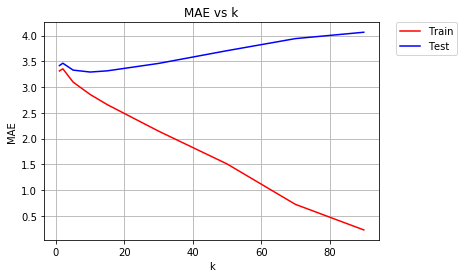

In [165]:
ks = [1,2,5,10,15,30,50,70,90]
train_MAEs = []
test_MAEs = []
for k in ks:
    train_MAE, test_MAE = mySVD(k)
    train_MAEs.append(train_MAE)
    test_MAEs.append(test_MAE)
fig = plt.figure()
plt.plot(ks, train_MAEs, 'r', label="Train")
plt.plot(ks, test_MAEs, 'b', label="Test")
plt.xlabel("k")
plt.ylabel("MAE")
plt.title("MAE vs k")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()
fig.savefig("MAE vs k")

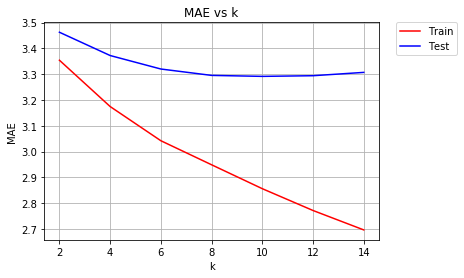

In [166]:
ks = [2,4,6,8,10,12,14]
train_MAEs = []
test_MAEs = []
for k in ks:
    train_MAE, test_MAE = mySVD(k)
    train_MAEs.append(train_MAE)
    test_MAEs.append(test_MAE)
fig = plt.figure()
plt.plot(ks, train_MAEs, 'r', label="Train")
plt.plot(ks, test_MAEs, 'b', label="Test")
plt.xlabel("k")
plt.ylabel("MAE")
plt.title("MAE vs k")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()
fig.savefig("MAE vs k")

In [6]:
#Baseline Model
#Train has been masked for computing user_bias
user_bias = train.mean(axis=1)
#prediction_baseline = np.zeros(test.shape) + train_average_row[:,np.newaxis]
prediction_baseline = np.zeros(test.shape) + user_bias[:,np.newaxis]
print 'Baseline Model Train MAE: ' + str(get_mae(prediction_baseline,train))
print 'Baseline Model Test MAE: ' + str(get_mae(prediction_baseline,test))

Baseline Model Train MAE: 3.65278144647
Baseline Model Test MAE: 3.73905334537


In [6]:
#Fcn to compute user or item similarity
from sklearn.metrics.pairwise import cosine_similarity

def similarity(ratings, kind='user'):
    if kind == 'user':
        sim = cosine_similarity(ratings)
        assert(sim.shape[0] == ratings.shape[0])
    elif kind == 'item':
        sim = cosine_similarity(ratings.T)
        assert(sim.shape[0] == ratings.shape[1])
    sim[np.isnan(sim)] = 0
    np.fill_diagonal(sim,0)
    return sim

In [7]:
#Compute item and user similarity
item_similarity = similarity(train, kind='item')
user_similarity = similarity(train, kind='user')
#Copy them for finding index in KNN
item_similarity_fcn = item_similarity.copy()
user_similarity_fcn = user_similarity.copy()
#Copy them for computing Top K CF based
item_similarity_CF = item_similarity.copy()
user_similarity_CF = user_similarity.copy()

In [10]:
def predict(ratings, similarity, kind ='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis = 1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = np.ma.dot(similarity, ratings) / np.array([np.abs(similarity).sum(axis=1)+1e-6]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis = 0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = np.ma.dot(ratings, similarity) / np.array([np.abs(similarity).sum(axis=1)+1e-6])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [9]:
user_prediction = predict(train, user_similarity, kind = 'user')
print 'User-based CF Train MAE: ' + str(get_mae(user_prediction, train))
print 'User-based CF Test MAE: ' + str(get_mae(user_prediction, test))

User-based CF Train MAE: 3.42836222924
User-based CF Test MAE: 3.50437041372


In [10]:
item_prediction = predict(train, item_similarity, kind = 'item')
print 'Item-based CF Train MAE: ' + str(get_mae(item_prediction, train))
print 'Item-based CF Test MAE: ' + str(get_mae(item_prediction, test))

Item-based CF Train MAE: 3.60228285891
Item-based CF Test MAE: 3.62044944882


In [11]:
#Compute KNN fcn to find K neighbors
def KNN(matrix_KNN, K):
    length_KNN = len(matrix_KNN)
    result_KNN = [[0]*K for i in range(len(matrix_KNN))]
    for indexI in range(length_KNN):
        for indexJ in range(K):
            maxtmp = np.max(matrix_KNN[indexI])
            result_KNN[indexI][indexJ] = np.where(matrix_KNN == maxtmp)
            matrix_KNN[np.where(matrix_KNN == maxtmp)]= 0
    return result_KNN      

In [12]:
#Pick K and call KNN Fcn to find OPTION2
k = 5
item_similarity_KNN_index  = KNN(item_similarity_fcn, k)
#Save index into a list (100,k)
item_similarity_KNN_index_final = [[0]*k for i in range(len(item_similarity_KNN_index))]
for indexI in range(len(item_similarity_KNN_index)):
    for indexJ in range(k):
        if indexI == item_similarity_KNN_index[indexI][indexJ][1][0]:
            temp = item_similarity_KNN_index[indexI][indexJ][1][1]
        else:
            temp = item_similarity_KNN_index[indexI][indexJ][1][0]
        item_similarity_KNN_index_final[indexI][indexJ] = temp

In [36]:
#KNN for item based OPTION1
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=30, algorithm='ball_tree').fit(item_similarity_fcn)
KNN_result = nbrs.kneighbors_graph(item_similarity_fcn).toarray()

In [37]:
#Make CF based on Item prediction that store values into list
item_similarity_CF_final = np.zeros((100,100))
for indexI in range(100):
    #Conversion for call sklearn KNN lib
    item_similarity_KNN_index_final = list(KNN_result[indexI].nonzero()[0])
    #OPTION2
    #for item in item_similarity_KNN_index_final[indexI]:
    #OPTION1
    for item in item_similarity_KNN_index_final:   
        item_similarity_CF_final[indexI][item] = item_similarity[indexI][item]

In [38]:
item_prediction_CFKNN = predict(train, item_similarity_CF_final, kind = 'item')
print 'Item-based CF Train MAE: ' + str(get_mae(item_prediction_CFKNN, train))
print 'Item-based CF Test MAE: ' + str(get_mae(item_prediction_CFKNN, test))

Item-based CF Train MAE: 3.42016175529
Item-based CF Test MAE: 3.43812779402


In [ ]:
#KNN for user based OPTION1
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(user_similarity_fcn)
KNN_result_user = nbrs.kneighbors_graph(user_similarity_fcn).toarray()

In [ ]:
#Make CF based on User prediction that store values into list
user_similarity_CF_final = np.zeros((24983,24983))
for indexI in range(24983):
    user_similarity_KNN_index_final = list(KNN_result_user[indexI].nonzero()[0])
    for user in user_similarity_KNN_index_final:
        user_similarity_CF_final[indexI][user] = user_similarity[indexI][user]

In [ ]:
user_prediction_CFKNN = predict(train, item_similarity_CF_final, kind = 'item')
print 'User-based CF Train MAE: ' + str(get_mae(user_prediction_CFKNN, train))
print 'User-based CF Test MAE: ' + str(get_mae(user_prediction_CFKNN, test))

In [8]:
#Do compution for similarity is less than 0.3
user_sim_nearest_neighbor = user_similarity.copy()
user_sim_nearest_neighbor[np.abs(user_sim_nearest_neighbor)<0.3] = 0

item_sim_nearest_neighbor = item_similarity.copy()
item_sim_nearest_neighbor[np.abs(item_sim_nearest_neighbor)<0.3] = 0

In [12]:
user_prediction = predict(train, user_sim_nearest_neighbor, kind = 'user')
print 'User-based CF Train MAE: ' + str(get_mae(user_prediction, train))
item_prediction = predict(train, item_sim_nearest_neighbor, kind = 'item')
print 'Item-based CF Train MAE: ' + str(get_mae(item_prediction, train))
user_prediction = predict(train, user_sim_nearest_neighbor, kind = 'user')
print 'User-based CF Test MAE: ' + str(get_mae(user_prediction, test))
item_prediction = predict(train, item_sim_nearest_neighbor, kind = 'item')
print 'Item-based CF Test MAE: ' + str(get_mae(item_prediction, test))


User-based CF Train MAE: 3.43634278345
Item-based CF Train MAE: 3.6836462091
User-based CF Test MAE: 3.51731365556
Item-based CF Test MAE: 3.70526069104
